<a href="https://colab.research.google.com/github/PhDroid-Fin/Machine-Learning-Theories/blob/master/Replication_KKX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating KKX paper


## Model Structure

![alt text](https://drive.google.com/uc?id=1alAHl5UwnMLQ4Q7CpuMduKfJl4M34mwJ)
<p align="center">

## 0. Environment Setup






In [0]:
# Simulation and IS estimation
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from itertools import compress # for extracting elements based on boolean indices
# OOS prediction
import cvxopt
from cvxopt import solvers, matrix # website for operation documentation: https://cvxopt.org/userguide/matrices.html
import pdb
from scipy import stats

## 1. Simulation


We assume the data generating process of the positive, negative, and neutral words in each article follows:
$$
d_{i,[S]} \sim \text{Multinomial}(s_i, p_i O_{+}+(1-p)O_{-})\\
d_{i,[N]} \sim \text{Multinomial}(n_i, O_0)
$$
where $p_i \sim \text{Unif}(0,1), s_i \sim \text{Unif}(0,2\bar{s}), n_i \sim \text{Unif}(0,2\bar{n})$, and for $j = 1,2,...,|S|,$
$$
O_{+,j} = \frac{2}{|S|}(1-\frac{j}{|S|})^2 + \frac{2}{3|S|}\times 1_{\{j<\frac{|S|}{2}\}} \\
O_{-,j} = \frac{2}{|S|}(\frac{j}{|S|})^2 + \frac{2}{3|S|}\times 1_{\{j\geq \frac{|S|}{2}\}}
$$ 
and $O_{0,j}$ is drawn from $\frac{1}{m-|S|}\text{Unif}(0,2)$, for $j = |S|+1,...,m$, then renormalized such that $\sum_j O_{0,j}=1$.

Next, the sign of returns follows a logistic regression model: $P(y_i > 0) = p_i$, and its magnitude $|y_i|$ follows a standard Student $t$-distribution with the degree of freedom parameter set at $4$. The standard deviation of the $t$-distribution has negligible effects on our simulations, since only the ranks of returns matter.

We fix the number of Monte Carlo repetitions $Mc = 200$ and the number of articles in the testing sample is $1,000$. In the benchmark case, we set $|S| = 100, m = 500, n = 10,000, \bar{s} = 10, \bar{n } = 100$.

### 1.1 Define simulation function: `sim_article(S_norm,m,n,s_bar,n_bar)`

In [0]:
#------ The following is based on a single stock ------#
def sim_article(S_norm,m,n,s_bar,n_bar,seed_val):
  # Parameter setup
  np.random.seed(seed_val) # set random seed so that results are replicatable
  # create word list
  pos_list = []
  neg_list = []
  neu_list = []
  for ele in range(int(S_norm/2)):
    if ele < 10:
      temp_pos = 'A_positive_0'+str(ele)
    else:
      temp_pos = 'A_positive_'+str(ele)
    pos_list.append(temp_pos)
    if ele < 10:
      temp_neg = 'B_negative_0'+str(ele)
    else:
      temp_neg = 'B_negative_'+str(ele)
    neg_list.append(temp_neg)
  for ele in range(m-S_norm):
    if ele < 10:
      temp_neu = 'C_neutral_0'+str(ele)
    else:
      temp_neu = 'C_neutral_'+str(ele)
    neu_list.append(temp_neu)
  sen_list = np.concatenate((pos_list,neg_list))

  # create random variables
  # create O_{+,j} and O_{-,j}
  O_plus = np.zeros((S_norm,1))
  O_minus = np.zeros((S_norm,1))
  for ele in range(S_norm):
      j = ele+1
      if j < int(S_norm/2):
          O_plus[ele] = 2/S_norm*(1-j/S_norm)**2+2/(3*S_norm)
          O_minus[ele] = 2/S_norm*(j/S_norm)**2
      else:
          O_plus[ele] = 2/S_norm*(1-j/S_norm)**2
          O_minus[ele] = 2/S_norm*(j/S_norm)**2+2/(3*S_norm)
  O_zero = np.zeros((m-S_norm,1))
  O_zero = 1/(m-S_norm)*np.random.uniform(0,2,m-S_norm) #low,high,size
  O_zero = O_zero/np.sum(O_zero) # renormalized to have prob sum = 1

  # DGP of pos, neg and neu words in each article i
  # 1.1 P(y_i>0) = p_i
  p_i = np.random.uniform(0,1,n)
  # 1.2 total counts of sentimental words in article i
  s_i = np.random.uniform(0,2*s_bar,n)
  # 1.3 total counts of neutral words in article i
  n_i = np.random.uniform(0,2*n_bar,n)
  # 2.1 sentimental words DGP
  d_S = []
  d_N = []
  for i in range(n):
    prob_temp = p_i[i]*O_plus+(1-p_i[i])*O_minus
    res_temp = np.random.multinomial(s_i[i],prob_temp)
    d_S = np.concatenate((d_S,res_temp))
    prob_temp = O_zero
    res_temp = np.random.multinomial(n_i[i],prob_temp)
    d_N = np.concatenate((d_N,res_temp))
  d_S = d_S.reshape(n,S_norm) 
  d_N = d_N.reshape(n,m-S_norm) 
  d_S = d_S.astype(int)
  d_N = d_N.astype(int)

  # create returns y_i using p_i; sgn(y_i) follows a logistic model ???
  y_sgn = 2*np.random.binomial(1,p_i,n)-1  # p_i already given, should be a binomial model
  y_mag = abs(np.random.standard_t(4,n))      # Student t with df = 4
  y_i = np.multiply(y_sgn,y_mag)

  # create n articles with given distribution of words
  # print('sen words list',sen_list)
  # print('neu words list',neu_list)
  # print('d_S',d_S)
  # print('d_N',d_N)
  article = []
  an_article = []
  for i in range(n):
    # print('-'*30,'i=',i,'-'*30)
    freq_S = d_S[i,]
    freq_N = d_N[i,]
    an_article_S = [[sen_list[j]]*freq_S[j] for j in range(len(sen_list))] # repeat words with given frequency
    an_article_N = [[neu_list[j]]*freq_N[j] for j in range(len(neu_list))] # repeat words with given frequency
    an_article = an_article_S+an_article_N
    # print('*'*10)
    # print('words in article ',i,' is ',an_article)
    # print(len(an_article))
    an_article = [item for sublist in an_article for item in sublist]
    # print('flattened article is ',an_article)
    # print(len(an_article))
    article = article+[an_article]
  # print('-'*30,'end of loop','-'*30)
  # print(article)
  # print('Is n equal to the number of lists?',len(article)==n)

  return article, y_i, p_i, O_plus, O_minus, s_i, d_S

### 1.2 Generate Simulation Data

In [0]:
#------------------------  Simulate the data  ----------------------------#
# random seed
seed_val = 0
# number of sentimental words
S_norm = 100
# number of total words
m = 500
# number of articles
n = 10000
# distribution parameters
s_bar = 10 # change of here
n_bar = 100
# observe simulation data
article, y_i, p_i, O_plus, O_minus, s_i, d_S = sim_article(S_norm,m,n,s_bar,n_bar,seed_val)

## 2. In-sample Estimation


### 2.1 Data Praparation


As an econometrician, we are able to observe the following data of a single stock:
1. Stock returns stamped with article $i$:
$$
  y_i,  \ \ \ \ \ \  i = 1,...,n
$$
2. Word counts vector of articles associated with returns:
$$
  D = [d_1,...,d_n], \\
  d_i = 
  \begin{bmatrix}
    d_{i,1} \\
    \vdots \\
    d_{i,m}
  \end{bmatrix}
$$
And to gain $m\times n$ matrix $D$ we need to convert articles into the vector of word counts

In [0]:
#------------------------  Prepare the data  ----------------------------#
# feel the data
# print('article data: \n',article)
# print('return data, y_i: \n',y_i)

# create word count matrix D
#1.flatten article
article_flat = [item for sublist in article for item in sublist]
#2.collect unique words and order them
word_uniq = list(set(article_flat))  # Sets are unordered collections of distinct objects
word_uniq.sort()
#3.create dictionary
D_dic = []
for i in range(len(article)):
  temp = {ele:article[i].count(ele) for ele in word_uniq}
  D_dic.append(temp)
# print(D_dic)
#4.create word count matrix D
D = []
for i in range(len(article)):
  temp = [article[i].count(ele) for ele in word_uniq]
  D = np.concatenate((D,temp))
D = D.reshape(n,len(word_uniq)) # D is the word count matrix with dimension n by m

In [32]:
#------------------------  Descriptive analysis  ----------------------------#
# 1. check simulated data
print('The unique words of all articles are:\n {} \n'.format(word_uniq) )
print('There are ', len(article), ' articles and ',len(word_uniq), ' unique words in totoal.\n')
print('The D[0] matrix is:\n',D[0])
print('The dS[0] matrix is:\n',D[0][0:100])
# i = 0
# print('Sentimental word count vector of the {}th article: \n {}'.format(i+1,D[i,0:S_norm]))
# check if tone predicts the return sign
# ret_sgn = np.sign(y_i)
# num_pos = [np.sum(D[i,0:int(S_norm/2)]) for i in range(len(article))]
# num_neg = [np.sum(D[i,int(S_norm/2):S_norm]) for i in range(len(article))]
# print('Number of positive words of the {}th article: \n {}'.format(i+1,num_pos))
# print('Number of negative words of the {}th article: \n {}'.format(i+1,num_neg))
# print('Number of net positive words of the {}th article: \n {}'.format(i+1,num_pos-num_neg))
# print('Return sign labled with the {} article is: \n {}'.format(i+1, ret_sgn))
# tone = np.array(num_pos) - np.array(num_neg)


The unique words of all articles are:
 ['A_positive_00', 'A_positive_01', 'A_positive_02', 'A_positive_03', 'A_positive_04', 'A_positive_05', 'A_positive_06', 'A_positive_07', 'A_positive_08', 'A_positive_09', 'A_positive_10', 'A_positive_11', 'A_positive_12', 'A_positive_13', 'A_positive_14', 'A_positive_15', 'A_positive_16', 'A_positive_17', 'A_positive_18', 'A_positive_19', 'A_positive_20', 'A_positive_21', 'A_positive_22', 'A_positive_23', 'A_positive_24', 'A_positive_25', 'A_positive_26', 'A_positive_27', 'A_positive_28', 'A_positive_29', 'A_positive_30', 'A_positive_31', 'A_positive_32', 'A_positive_33', 'A_positive_34', 'A_positive_35', 'A_positive_36', 'A_positive_37', 'A_positive_38', 'A_positive_39', 'A_positive_40', 'A_positive_41', 'A_positive_42', 'A_positive_43', 'A_positive_44', 'A_positive_45', 'A_positive_46', 'A_positive_47', 'A_positive_48', 'A_positive_49', 'B_negative_00', 'B_negative_01', 'B_negative_02', 'B_negative_03', 'B_negative_04', 'B_negative_05', 'B_negat

### 2.2 Isolate $S$ via Algorithm 1


S1. For each word $1\leq j \leq m$ ,let
$$
f_j = \frac{\text{# articles including word $j$ AND having sgn(y) = 1}}{
\text{# articles including word $j$}}
$$

S2. For a proper threshold $\alpha_+ > 0, \alpha_− > 0$, and $\kappa > 0$ to be determined, construct
$$
\hat{S}=\{j :f_j \geq 1/2+\alpha_+\} \cup \{j :f_j \leq 1/2−\alpha_−\}\cap\{j :k_j \geq \kappa\},
$$
where $k_j$ is the total count of articles in which word $j$ appears.

In [0]:
#1 create f_j and k_j
#1.1 create f_j
dmy_word_j = [D.T[j]>0 for j in range(len(word_uniq))]
y_sgn = y_i>0
# print('sgn(y)      ',np.array(y_sgn))
# print('dummy_word_j',np.array(D.T[j]>0))
# print(np.array(D.T[j]>0) & np.array(y_sgn))
dmy_word_j_and_sgn_plus = [np.array(D.T[j]>0) & np.array(y_sgn) for j in range(len(word_uniq))]
# print(dmy_word_j)
# print(dmy_word_j_and_sgn_plus)
f_j = [np.sum(dmy_word_j_and_sgn_plus[j])/np.sum(dmy_word_j[j]) for j in range(len(word_uniq))]
# print('f_j is \n',f_j)
#1.2 create k_j
k_j = [np.sum(dmy_word_j[j]) for j in range(len(word_uniq))]
# print('k_j is \n',k_j)
# print(word_uniq)

#2 create S_hat 
#2.1 create criterion for f_j
f_j_crit = np.logical_or(np.array(f_j)>np.quantile(f_j,.9),np.array(f_j)<np.quantile(f_j,.1))
#2.2 create criterion for k_j
k_j_crit = k_j > np.quantile(k_j, .1)
# print(k_j_crit)
#2.3 create S_hat
S_crit = np.logical_and(f_j_crit,k_j_crit)
S_hat = list(compress(word_uniq, S_crit))


In [34]:
#------------------------  Descriptive analysis  ----------------------------#
# check S_hat
print('-'*30)
print('S_hat should collect only sentimental words, if criteria for f_j and k_j are reasonable')
print('-'*30)
print('The number of sentimental words in S_hat is: \n {}(True number is {})'.format(np.sum(S_crit),S_norm) )
print('Sentimental words in S_hat are: \n {}'.format(S_hat))
ind_neu = ['neu' in ele for ele in S_hat]
print('Does S_hat contain neutral words? \n {}'.format(np.sum(ind_neu)>0))

------------------------------
S_hat should collect only sentimental words, if criteria for f_j and k_j are reasonable
------------------------------
The number of sentimental words in S_hat is: 
 94(True number is 100)
Sentimental words in S_hat are: 
 ['A_positive_00', 'A_positive_01', 'A_positive_02', 'A_positive_03', 'A_positive_04', 'A_positive_05', 'A_positive_06', 'A_positive_07', 'A_positive_08', 'A_positive_09', 'A_positive_10', 'A_positive_11', 'A_positive_12', 'A_positive_13', 'A_positive_14', 'A_positive_15', 'A_positive_16', 'A_positive_17', 'A_positive_18', 'A_positive_19', 'A_positive_20', 'A_positive_21', 'A_positive_22', 'A_positive_23', 'A_positive_24', 'A_positive_25', 'A_positive_26', 'A_positive_27', 'A_positive_28', 'A_positive_29', 'A_positive_30', 'A_positive_31', 'A_positive_32', 'A_positive_33', 'A_positive_34', 'A_positive_35', 'A_positive_36', 'A_positive_37', 'A_positive_38', 'A_positive_39', 'A_positive_40', 'A_positive_41', 'A_positive_42', 'A_positive_43

### 2.3 Estimate $O$ and $p_i$ via Algorithm 2


S1. Sort the returns $\{y_i\}^n_{i=1}$ in ascending order. For each $1 \leq i \leq n$, let 
$$
\hat{p}_i = \frac{\text{rank of } y_i \text{ in all returns.}}{n}
$$

S2.For $1 \leq i \leq n$, let $\hat{s}_i$ be the total counts of words from $S$ in article $i$, and let $\hat{d}_i = \hat{s}_i^{-1} d_{i,[\hat{S}]}$ .

Write $\hat{D} = [\hat{d}_1, \hat{d}_2, . . . , \hat{d}_n]$. Construct
$$
\hat{O} = \hat{D}\hat{W}′(\hat{W}\hat{W}′)^{−1}, \\
\hat{W} = \begin{bmatrix} 
          \hat{p}_1 & \hat{p}_2 & \cdots & \hat{p}_n \\
          1-\hat{p}_1 & 1-\hat{p}_2 & \cdots & 1-\hat{p}_n
          \end{bmatrix}. 
$$
Set negative entries of $\hat{O}$ to zero and re-normalize each column to have a unit $l^1$-norm. We use the same notation $\hat{O}$ for the resulting matrix. We also have $\hat{O} = [\hat{O}_+, \hat{O}_−]$.

In [35]:
#1. estimate p_i
#1.1 sort returns and get ranks
ind = np.argsort(y_i)
y_ordered = np.take_along_axis(y_i, ind, axis=None) 
y_ID_mixed = np.take_along_axis(np.arange(len(y_i)), ind, axis=None)
ind_rev = np.argsort(y_ID_mixed)
y_rank = np.take_along_axis(np.arange(len(y_i)), ind_rev, axis=None)
# print(y_rank)
#1.2 estimate p
pi_hat = y_rank/len(y_i)
# print(pi_hat)

#2. estimate O
#2.1 construct D_hat
#2.1.1 construct d_iS
d_iS_All = []
for i in range(len(article)):
  d_iS = [D[i][word_uniq.index(ele)] for ele in S_hat] # D is (n,m)
  d_iS_All = np.concatenate((d_iS_All,d_iS))
d_iS_All = d_iS_All.reshape((len(article),len(S_hat)))
print(d_iS_All)
#2.1.1 construct si_hat
# print(d_iS[1])
si_hat = [np.sum(d_iS_All[i]) for i in range(len(article))]
si_hat = np.array(si_hat)
si_hat = si_hat.reshape((n,1))
print(si_hat)
#2.1.2 construct D_hat: |S| by n
D_hat = [d_iS_All[i]/si_hat[i] if si_hat[i]!= 0 else np.zeros((len(S_hat),)) for i in range(len(article))] # n by |S|
D_hat = np.matrix(D_hat).T # |S| by n
# print(D_hat)
#2.2 construct W_hat: 2 by n
W_hat = np.matrix([pi_hat,1-pi_hat])
# print(W_hat)
#2.3 estimate O = DW'(WW')^-1: |S| by 2
O_hat = D_hat*W_hat.T*np.linalg.inv(W_hat*W_hat.T)
O_hat[O_hat<0] =0 # set negative values to zero
O_hat = O_hat/np.sum(O_hat,axis = 0) # re-normalize each column

[[0. 0. 0. ... 2. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[14.]
 [11.]
 [10.]
 ...
 [14.]
 [15.]
 [ 7.]]


In [36]:
#------------------------  Descriptive analysis  ----------------------------#
print('-'*30)
print('For O_hat to behave reasonable, check if T = (O_+ - O_-) have predictive power over p_i')
print('-'*30)
# 1. T = O_plus - O_minus should >0 for positive words in S_hat
T = O_hat[:,0] - O_hat[:,1]
temp = T>0
ind_T = [temp[i][0] == ['pos' in S_hat[i]] for i in range(len(S_hat))]
print('Accuracy of T in selecting sentimental words is: \n {}'.format(np.sum(ind_T)/len(ind_T)))

# Debug check for pi_hat
print('-'*30)
print('pi_hat is constructed from y_i, so it should have large correlation with y_i.\n\
Most importantly, if we see big positive correlation btw pi_hat and p_i, then pi_hat has predictive power over p_i, which is desired')
print('-'*30)
acc_p_y = np.sum(np.sign(pi_hat-.5)==np.sign(y_i))/len(p_i)
print('{}> 0.5? {}'.format(acc_p_y,acc_p_y>.5))
acc_p_p = np.sum(np.sign(pi_hat-.5)==np.sign(p_i-.5))/len(p_i)
print('{}> 0.5? {}'.format(acc_p_p,acc_p_p>.5))
print('Corr(pi_hat, p_i) = \n {}'.format(np.corrcoef(pi_hat,p_i)))
print('Corr(pi_hat, y_i) = \n {}'.format(np.corrcoef(pi_hat,y_i)))
print('Corr(sgn(pi_hat-0.5), sgn(p_i-0.5)) = \n {}'.format(np.corrcoef(np.sign(pi_hat-.5),np.sign(p_i-.5))))
print('Corr(sgn(pi_hat-0.5), sgn(y_i-0.5)) = \n {}'.format(np.corrcoef(np.sign(pi_hat-.5),np.sign(y_i))))

------------------------------
For O_hat to behave reasonable, check if T = (O_+ - O_-) have predictive power over p_i
------------------------------
Accuracy of T in selecting sentimental words is: 
 1.0
------------------------------
pi_hat is constructed from y_i, so it should have large correlation with y_i.
Most importantly, if we see big positive correlation btw pi_hat and p_i, then pi_hat has predictive power over p_i, which is desired
------------------------------
0.9982> 0.5? True
0.7481> 0.5? True
Corr(pi_hat, p_i) = 
 [[1.         0.49354061]
 [0.49354061 1.        ]]
Corr(pi_hat, y_i) = 
 [[1.         0.90592712]
 [0.90592712 1.        ]]
Corr(sgn(pi_hat-0.5), sgn(p_i-0.5)) = 
 [[1.         0.49639823]
 [0.49639823 1.        ]]
Corr(sgn(pi_hat-0.5), sgn(y_i-0.5)) = 
 [[1.         0.99655593]
 [0.99655593 1.        ]]


In [37]:
print('-'*30)
print('There are cases where we see s_i = 0.\n\
Since we have DGP: d_iS = MN(s_i, pi*O_plus + (1-pi)*O_minus), it means that either s_i~0 or pi*O_plus+(1-pi)*O_minus~0')
print('-'*30)
# count = 0
# for i in range(len(article)):
#   word_count = np.sum(D[i][0:S_norm])
#   if word_count == 0:
#     count += 1
#     # print(D[i][0:S_norm])
# print('{}/{} = {} have zero s_i'.format(count,len(article),count/len(article)))
# s_i
# print('Number of zero values of si_hat are: \n {}'.format(np.sum(si_hat==0)))
# print('Number of zero values of s_i (in MN r.v.) are: \n {}'.format(np.sum(s_i==0)))
count = 0
for i in range(len(article)):
  word_count = np.sum(d_S[i][0:S_norm])
  if word_count == 0:
    count += 1
print('Number of zero values in d_S (DGP) are: \n {}'.format(count))
MN_prob = np.array([], dtype=np.int64).reshape(0,1)
for i in range(n):
  temp = p_i[i]*O_plus+(1-p_i[i])*O_minus
  MN_prob = np.concatenate((MN_prob,temp))
MN_zero = np.array([], dtype=np.int64).reshape(0,)
for i in range(n):
  if s_i[i]>0:
    temp = MN_prob[i]
    MN_zero = np.concatenate((MN_zero,temp))
print(MN_zero)

------------------------------
There are cases where we see s_i = 0.
Since we have DGP: d_iS = MN(s_i, pi*O_plus + (1-pi)*O_minus), it means that either s_i~0 or pi*O_plus+(1-pi)*O_minus~0
------------------------------
Number of zero values in d_S (DGP) are: 
 552
[0.01054175 0.01038725 0.01023674 ... 0.01278959 0.01298124 0.0131769 ]


In [38]:
print(np.sum(s_i==0))
# for i in range(n):
#   if si_hat[i] == 0:
#     print(s_i[i])
print(s_i[0:100])
print(d_S[0])


0
[15.39239008 11.65702536 10.95670116  0.99991983 13.53463066 11.3086035
 10.31800313 15.32889361 15.65980796  4.33381305  3.69298433 13.19333073
  6.61604699  9.09558306  0.88754653  8.45877882 18.83697941 13.75337192
 16.38810995 12.55049429 11.70216821 19.41709909  9.79427757 15.80603926
  4.62821922  2.03922269  3.62653984  6.84608234  9.21365711 17.78774075
 11.85251063 12.85220186  7.69898094 13.39239877  8.08231892 12.1613823
 10.7162001   6.15813084  1.67204959  2.45207842 11.49811292  1.46222856
  9.06111137 17.98121875 11.65278148 19.53325919  5.75761646 12.99826867
 18.69509791  6.98808505 10.67161095 16.94356942  6.6266937   0.17907074
 19.80451037  8.12245153  2.18949995 14.72054935  6.50118992  3.36913462
  2.36981033 13.9514723  19.86524429  7.83829364 15.27477216 13.0848064
  8.41923019  0.97867881  8.18857909  0.58531368 19.04483288  8.18776416
 11.58480375 18.8146976  11.5204923   3.44657856 19.03227158  3.75879741
  2.56292287  7.24902876  8.69701672 19.54745012 11.

## 3. Out-of-sample Prediction

### 3.1 Nonlinear `cvxopt` problem


**`cvxopt.solvers.cp(F[, G, h[, dims[, A, b[, kktsolver]]]])`**

According to documentation of `cvxopt` the problem should be transformed into the following format:
$$
    \begin{aligned}
        & \min f_0(x) \\
        \text{s.t.} \\
        & f_k(x) \leq 0, \ k = 1,...,m \ \ \ \ \ \textbf{ no such constraints}\\
        & Gx \preceq h \\
        & Ax = b \ \ \ \ \ \textbf{ no such constraints}
    \end{aligned}
$$

The argument `F` is a function that evaluates the objective and nonlinear constraint functions. It must handle the following calling sequences.

- `F()` returns a tuple (`m`, `x0`), where $m$ is the number of nonlinear constraints and $x_0$ is a point in the domain of $f$. `x0` is a dense real matrix of size $(n, 1)$.
  - Since we don't have nonlinear constraints, we have $m = 0$

- `F(x)`, with `x` a dense real matrix of size $(n, 1)$, returns a tuple `(f, Df)`. `f` is a dense real matrix of size $(m+1, 1)$, with `f[k]` equal to `f_k(x)`. (If `m` is zero, f can also be returned as a number.) `Df` is a dense or sparse real matrix of size $(m + 1, n)$ with `Df[k,:]` equal to the transpose of the gradient $\nabla f_k(x)$. If `x` is not in the domain of `f`, `F(x)` returns `None` or a tuple `(None, None)`.

- `F(x,z)`, with x a dense real matrix of size $(n, 1)$ and `z` a positive dense real matrix of size $(m + 1, 1)$ returns a tuple `(f, Df, H)`. `f` and `Df` are defined as above. `H` is a square dense or sparse real matrix of size $(n, n)$, whose lower triangular part contains the lower triangular part of
$$
z_0 \nabla^2f_0(x) + z_1 \nabla^2f_1(x) + \cdots +
    z_m \nabla^2f_m(x).
$$

- If $F$ is called with two arguments, it can be assumed that $x$ is in the domain of $f$.
---
#### Example:
$$ 
\begin{align}
 \min &- \sum_{t=1}^{T} \log x_t\\
 \text{s.t. } &Ax=b
\end{align}
$$
where 
$$
\begin{align}
  A &= 
  \begin{bmatrix}
    1 && 2&& 3\\
    2 && 3&& 4
  \end{bmatrix} \\
  b &= 
  \begin{bmatrix}
    3\\5
  \end{bmatrix}
\end{align}
$$
- When constructing functions `f`, `Df` and `H`, try to use `numpy` first to get the right operation and then convert the result using `matrix` from `cvxopt`.

In [39]:
from cvxopt import solvers, matrix, spdiag, log
def acent(A, b):
  m, n = A.size  # m is not the same m in the introduction above
  print(m,n)
  def F(x=None, z=None):
      if x is None: return 0, matrix(1.0, (n,1)) # return 0 because we don't have nonlinear inequalities
      if min(x) <= 0.0: return None
      f = -sum(log(x))
      Df = -(x**-1).T
      if z is None: return f, Df
      H = spdiag(z[0] * x**-2)
      return f, Df, H
  # pdb.set_trace()
  return solvers.cp(F, A=A, b=b)['x']

temp = np.array([[1,2,3],[2,1,4]],dtype=float)
A_matrix = matrix(temp,(2,3))
print(A_matrix)
b_matrix = matrix([3.,2.])
res = acent(A_matrix,b_matrix)
print('Optimal x is: \n', res)

[ 1.00e+00  2.00e+00  3.00e+00]
[ 2.00e+00  1.00e+00  4.00e+00]

2 3
Optimal x is: 
 [ 1.71e-01]
[ 1.27e+00]
[ 9.74e-02]



###3.2 Score new articles: OOS prediction for $p$


Let $\hat{s}$ be the total count of words from $\hat{S}$ in the new article. Obtain $\hat{p}$ by:
$$
\hat{p} = \text{arg } \underset{p\in (0,1)}{\max} \{\hat{s}^{-1} \sum_{j=1}^{|\hat{S}|}d_j \log(p\hat{O}_{+,j}+(1-p)\hat{O}_{-,j})+\lambda\log(p(1-p)) \}
$$
where $d_j, \hat{O}_{+,j}$ and $\hat{O}_{−,j}$ are the $j$th entries of the corresponding vectors, and $\lambda > 0$ is a tuning parameter.

---
$$
\begin{align}
  \min & f_0(p) \\
  \text{s.t. } & Gp \leq h
\end{align}
$$

where we have:
$$
\begin{align}
  f_0(p) &= -\hat{s}^{-1} \sum_{j=1}^{|\hat{S}|}d_j \log(p\hat{O}_{+,j}+(1-p)\hat{O}_{-,j})-\lambda\log(p(1-p)) \\
  \nabla f_0 &= -\hat{s}^{-1} \sum_{j=1}^{|\hat{S}|}d_j \frac{\hat{O}_{+,j}-\hat{O}_{-,j}}{p\hat{O}_{+,j}+(1-p)\hat{O}_{-,j}} - \lambda(\frac{1}{p}-\frac{1}{1-p}) \\ 
  \nabla^2 f_0 &= \hat{s}^{-1} \sum_{j=1}^{|\hat{S}|}d_j \frac{(\hat{O}_{+,j}-\hat{O}_{-,j})^2}{(p\hat{O}_{+,j}+(1-p)\hat{O}_{-,j})^2} + \lambda(\frac{1}{p^2}+\frac{1}{(1-p)^2})
\end{align}
$$
where $\log_{\odot}$ represents the element-wise log function, and
$$
\begin{align}
  \hat{O} &= \begin{bmatrix}\hat{O}_+ & \hat{O}_- \end{bmatrix}\\
  G &= \begin{bmatrix} 1\\-1\end{bmatrix}\\
  h &= \begin{bmatrix} 1\\ 0\end{bmatrix}
\end{align}
$$

####3.2.1 Define functions: 


##### MLE estimator 

In [0]:
def MLE_for_p(s_new, dS_new, O_hat, lambda_value): 
# s_new is a scalar
# dS_new is (|S|,1)
# O_hat is (|S|,2)
# lambda is a scalar; optimal value found via OOS
  s_new = np.array(s_new, dtype=float)
  dS_new = np.array(dS_new, dtype=float)
  O_hat = np.array(O_hat, dtype=float)
  lambda_value = np.array(lambda_value, dtype=float)
  dS_new = matrix(dS_new, (len(dS_new),1))  # dS_new is an (|S|,1) vector
  O_hat_plus = matrix(O_hat[:,0])
  O_hat_minus = matrix(O_hat[:,1])
  G_matrix = matrix([1., -1.])
  h_matrix = matrix([1.,0.])
  num_ineq, len_arg = G_matrix.size  # num_ineq, len_arg represents number of inequalities and length of argument vector
  # print(num_ineq, len_arg)
  def F(x=None, z=None):
      if x is None: return 0, matrix(0.5, (len_arg,1))  # return 0, because m = 0; initial value = .1
      if min(x) <= 0.0 or max(x) >=1.0: return None # domain of f is in (0,1)
      # print('s_new is {}'.format(s_new),end='|')
      # f0 function
      f111 = matrix(dS_new) # dS_new is (|S_hat|,1)
      f112 = matrix(log(x*O_hat_plus+(1.-x)*O_hat_minus)) # (|S_hat|,1)
      f11 = matrix(np.sum(np.multiply(f111,f112)))
      f12 = matrix(s_new**-1)
      # print('f12',f12)
      f1 = -matrix(np.multiply(f11,f12)) # f1 = -1/s_new*sum(f11*f12), scalar
      f2 = -matrix(lambda_value*np.log(x*(1.-x)))
      f = matrix(f1+f2)
      # pdb.set_trace()

      # Df 1st order gradient
      Df11 = matrix(dS_new)
      Df121 = matrix(O_hat_plus - O_hat_minus)
      Df122 = matrix(x*O_hat_plus + (1.-x)*O_hat_minus)
      Df12 = matrix((np.multiply(Df121,Df122**-1)))
      Df1 = -matrix(s_new**-1*np.sum(np.multiply(Df11,Df12)))
      Df2 = -matrix(lambda_value*(x**-1-(1.-x)**-1))
      Df = matrix(Df1 + Df2)
      if z is None: return f, Df

      # pdb.set_trace()
      # H 2nd order gradient
      H11 = matrix(dS_new)
      H121 = matrix(O_hat_plus - O_hat_minus)
      H122 = matrix(x*O_hat_plus + (1.-x)*O_hat_minus)
      H12 = matrix(np.multiply(H121**2,H122**-2))
      H1 = matrix(s_new**-1*np.sum(np.multiply(H11,H12)))
      H2 = matrix(lambda_value*(x**-2+(1-x)**-2))
      H = matrix(H1 + H2)
      # pdb.set_trace()
      return f, Df, H
  return solvers.cp(F, G=G_matrix, h=h_matrix)['x']

##### Data prep for new articles

In [0]:
def prep_new_articles(article_new):
  #1.create word count matrix D_new
  D_new = []
  for i in range(len(article_new)):
    temp = [article_new[i].count(ele) for ele in word_uniq]
    D_new = np.concatenate((D_new,temp))
  D_new = D_new.reshape(len(article_new),len(word_uniq)) # D_new is the word count matrix with dimension (n_test,m)
  #2. construct dS_new
  dS_new = []
  for i in range(len(article_new)):
    temp = [D_new[i][word_uniq.index(ele)] for ele in S_hat] # D_new is (n_test,m)
    dS_new = np.concatenate((dS_new,temp))
  dS_new = dS_new.reshape((len(article_new),len(S_hat)))
  # print(dS_new) # (n_test, |S_hat|)
  #3. construct s_new
  s_new = [np.sum(dS_new[i]) for i in range(len(article_new))]
  s_new = np.array(s_new)
  s_new = s_new.reshape((len(article_new),1))
  # print(s_new)
  return s_new, dS_new

####3.2.2 OOS prediction of $p$ for new articles

In [0]:
# 1 Simulate test data
n_test = 1000
seed_val = 1
article_new, y_new, p_new, _ , _ , _ , _ = sim_article(S_norm,m,n_test,s_bar,n_bar,seed_val)
# 2 Data prep
s_new, dS_new = prep_new_articles(article_new)

In [0]:
#------------------------  Descriptive analysis  ----------------------------#
# print(s_new[0:10])
# print(dS_new[0:10][:])
# for i in range(len(s_new)):
#   if s_new[i] == 0:
#     print(dS_new[i])
# s_i = np.random.uniform(0,2*s_bar,n)
# print(np.sum(s_i == 0))


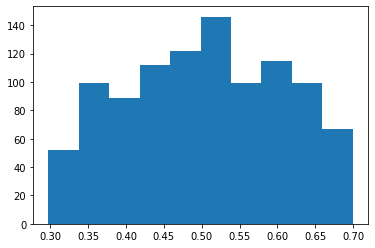

In [43]:
# 3 MLE estimator for p
cvxopt.solvers.options['show_progress'] = False
lambda_value = 0.5
p_MLE = np.array([])
for i in range(len(article_new)): 
  if s_new[i] != 0:
    temp = MLE_for_p(s_new[i], dS_new[i], O_hat, lambda_value)
  else:
    temp = [[.5]]
  temp = np.array(temp)
  # print(temp)
  p_MLE = np.concatenate((p_MLE,temp[0]))
# print(p_MLE)
plt.hist(p_MLE)
plt.show()
# print('x is: \n {}'.format(p_MLE))

#### 3.2.3 OOS accuracy

------------------------------
Since p_MLE only controls the *sign*, not the *magnitude* of y, 
we want to see if p_MLE has predictive power over signs of returns.
Notice that the relative values are of concerned, not the absolute value.
And this will be reflected in the approaches that we use here.
------------------------------
The OOS accuracy for signs of y is 0.708
The OOS accuracy for p_new is 0.809


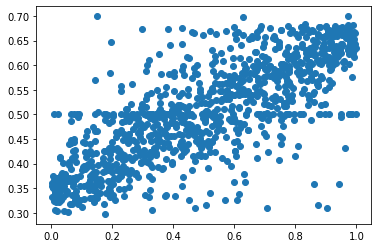

Corr(p_MLE, p_new) = 
 0.7604176970730552
Corr(dmy_p_pred, dmy_p_new) = 
 0.6196413514856266
Corr(dmy_p_pred, dmy_y_new) = 
 0.4181513909828524
Spearman rank correlation btw (p_MLE,p_new) is: 
SpearmanrResult(correlation=0.7630583054241832, pvalue=2.2520167513137738e-191)


In [44]:
print('-'*30)
print('Since p_MLE only controls the *sign*, not the *magnitude* of y, \n\
we want to see if p_MLE has predictive power over signs of returns.\n\
Notice that the relative values are of concerned, not the absolute value.\n\
And this will be reflected in the approaches that we use here.')
print('-'*30)

#1. create dummy variable dmy_p_new = 1{p>0}
dmy_p_pred = np.sign(p_MLE-.5)>0
dmy_y_new = np.sign(y_new) >0
acc_OOS = np.sum(dmy_p_pred == dmy_y_new)/len(dmy_y_new)
print('The OOS accuracy for signs of y is {}'.format(acc_OOS))
dmy_p_new = np.sign(p_new - .5) >0
acc_OOS_p = np.sum(dmy_p_pred == dmy_p_new)/len(dmy_y_new)
print('The OOS accuracy for p_new is {}'.format(acc_OOS_p))
plt.scatter(p_new,p_MLE)
plt.show()

# 2. check OOS predictability: correlation
print('Corr(p_MLE, p_new) = \n {}'.format(np.corrcoef(p_MLE,p_new)[0][1]))
print('Corr(dmy_p_pred, dmy_p_new) = \n {}'.format(np.corrcoef(dmy_p_pred,dmy_p_new)[0][1]))
print('Corr(dmy_p_pred, dmy_y_new) = \n {}'.format(np.corrcoef(dmy_p_pred,dmy_y_new)[0][1]))

# 3. Spearman's rank correlation coefficient
spmr_OS = stats.spearmanr(p_MLE,p_new)
print('Spearman rank correlation btw (p_MLE,p_new) is: \n{}'.format(spmr_OS))


In [0]:
#------------------------  Descriptive analysis  ----------------------------#


####3.2.4 IS prediction of $p$ for training articles

In [0]:
# 1 IS test data
n_IS = 1000
article_IS = article[0:n_IS]
y_IS = y_i[0:n_IS]
p_IS = p_i[0:n_IS]
# 2 Data prep
s_IS, dS_IS = prep_new_articles(article_IS)


In [0]:
#------------------------  Descriptive analysis  ----------------------------#
# print(s_IS[0:10])
# print(dS_IS[0:10][:])
# for i in range(len(s_IS)):
#   if s_IS[i] == 0:
#     print(dS_IS[i])
# s_i = np.random.uniform(0,2*s_bar,n)
# print(np.sum(s_i == 0))


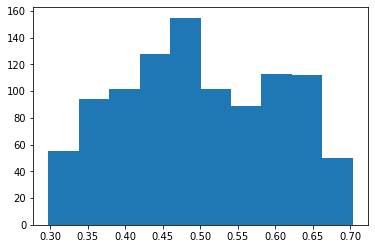

In [46]:
# 3 MLE estimator for p
cvxopt.solvers.options['show_progress'] = False
lambda_value = 0.5
p_MLE_IS = np.array([])
for i in range(len(article_IS)): 
  if s_IS[i] != 0:
    temp = MLE_for_p(s_IS[i], dS_IS[i], O_hat, lambda_value)
  else:
    temp = [[.5]]
  temp = np.array(temp)
  # print(temp)
  p_MLE_IS = np.concatenate((p_MLE_IS,temp[0]))
# print(p_MLE_IS)
plt.hist(p_MLE_IS)
plt.show()
# print('x is: \n {}'.format(p_MLE_IS))

#### 3.2.3 IS accuracy

The IS accuracy for signs of y is 0.72
The IS accuracy for p_new is 0.816


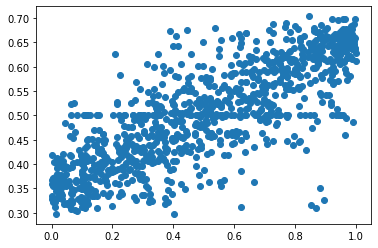

Corr(p_MLE, p_new) = 
 0.7948001076714046
Corr(dmy_p_pred_IS, dmy_p_IS) = 
 0.6324649203676812
Corr(dmy_p_pred_IS, dmy_y_IS) = 
 0.44154723689083153
Spearman rank correlation btw (p_MLE_IS,p_IS) is: 
SpearmanrResult(correlation=0.7968647906755041, pvalue=1.2264048913295018e-220)


In [47]:
#1. create dummy variable dmy_p_new = 1{p>0}
dmy_p_pred_IS = np.sign(p_MLE_IS-.5)>0
dmy_y_IS = np.sign(y_IS) >0
acc_IS = np.sum(dmy_p_pred_IS == dmy_y_IS)/len(dmy_y_IS)
print('The IS accuracy for signs of y is {}'.format(acc_IS))
dmy_p_IS = np.sign(p_IS - .5) >0
acc_IS_p = np.sum(dmy_p_pred_IS == dmy_p_IS)/len(dmy_y_IS)
print('The IS accuracy for p_new is {}'.format(acc_IS_p))
plt.scatter(p_IS,p_MLE_IS)
plt.show()

# 2. check OOS predictability: correlation
print('Corr(p_MLE, p_new) = \n {}'.format(np.corrcoef(p_MLE_IS,p_IS)[0][1]))
print('Corr(dmy_p_pred_IS, dmy_p_IS) = \n {}'.format(np.corrcoef(dmy_p_pred_IS,dmy_p_IS)[0][1]))
print('Corr(dmy_p_pred_IS, dmy_y_IS) = \n {}'.format(np.corrcoef(dmy_p_pred_IS,dmy_y_IS)[0][1]))

# 3. Spearman's rank correlation coefficient
spmr_IS = stats.spearmanr(p_MLE_IS,p_IS)
print('Spearman rank correlation btw (p_MLE_IS,p_IS) is: \n{}'.format(spmr_IS))

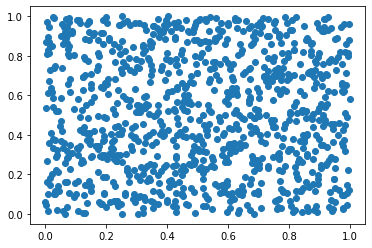

165
950
1000


In [48]:
# Debug: IS and new have different p_IS vs. p_new
plt.scatter(p_new,p_IS)
plt.show()
# print(dS_new[0:10])
# print(dS_IS[0:10])
print(np.sum(dS_new[0:10]!=dS_IS[0:10]))
print(np.sum(s_new!=s_IS))
print(np.sum(p_new!=p_IS))

